In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pickle
from copy import deepcopy

from brian2 import *

from scipy import signal
import string

In [3]:
# sys.path.append('/Users/simon/lib/code/brian_analysis')
sys.path.append('../code')

# from model import HH_model
import config
from viz import phase_shift, psth

from utils import get_label

from experiment import get_sinusoidal_signal, get_sinusoidal_parameters # , run_augmented_parameters

In [4]:
# text
plt.rcParams['text.usetex'] = True
plt.rcParams['pdf.fonttype'] = 42

# plotting
plt.rcParams['lines.linewidth'] = 0.75

In [5]:
import logging

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

logger = logging.getLogger()

In [6]:
def plot_frequency_response(freq_id, variable, exp_name='frequency_response', f_max=49, ax=None, data_dir='../data/', **kw):
    if ax is None:
        fig, ax = plt.subplots(1)
    file_path = os.path.join(data_dir, exp_name, freq_id, 'results.p')
    with open(file_path, 'rb') as tmp:
        data = pickle.load(tmp)
    fs = data['frequencies']
    y = data[variable]
    idx = np.argwhere(fs <= f_max)
    ax.plot(fs[idx], y[idx], **kw)
    ax.set_xscale('log')
    return ax

In [7]:
def get_lag_from_sinusoidals(r, sin_id, dt=1e-4, t_init=1., return_crosscorr=False, experiment_name='sinusoidals'):
    experiment_params = config.experiment[experiment_name][sin_id]
    if experiment_name == 'sinusoidals':
        frequencies = experiment_params['frequencies']
        amplitudes = experiment_params['amplitudes']
        phases = experiment_params.get('phases', None)
    else:
        raise NotImplementedError
    
    t_r = len(r) * dt

    t = np.arange(t_init - t_r, t_init + 2 * t_r, dt)
    I = get_sinusoidal_signal(frequencies=frequencies, amplitudes=amplitudes, phases=phases, t=t, zscore=True)
    
    cross = signal.correlate((r - r.mean())/r.std(), I)
    cross /= cross.max()
    
    lags = t_init + signal.correlation_lags(len(r), len(I)) * dt

    idx = len(r)
    cross = cross[idx:-idx]
    lags = lags[idx:-idx]
    
    lag = lags[np.argmax(cross)]
    
    if return_crosscorr:
        return lag, (lags, cross)
    else:
        return lag

-0.026000000000000023
-0.02300000000000013
-0.02300000000000013
-0.007000000000000117
-0.006000000000000005
-0.007000000000000117


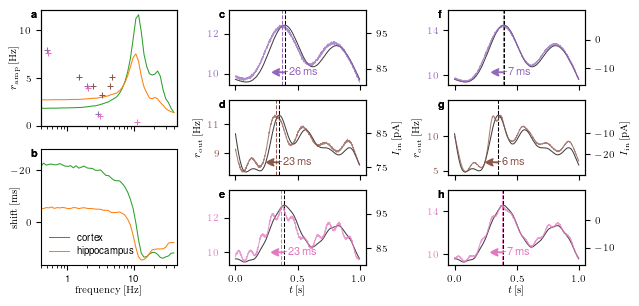

In [9]:

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

fontsize = 7
label_fontsize = 8
label_case = 'lower'

freq_id = '001'
sin_experiment = 'random_sinusoidals'
sin_experiment = 'sinusoidals'

plot_amplitudes = True


sin_ids = [['001', '002', '003'], ['004', '005', '006']]

colors_model = [plt.colormaps['tab10'](i) for i in [2, 1]]
colors_signal = [plt.colormaps['tab10'](i) for i in [4, 5, 6]]

bins = 1000

f_max = 40

ylabelpad = 0
xlabelpad = 2

cmap = plt.colormaps['tab10']

plot_kw = {'lw': 0.75}
plot_kw_sin = plot_kw.copy()
plot_kw_sin['alpha'] = 0.75
plot_kw_freq = plot_kw.copy()
plot_kw_freq['c'] = colors_model[0]

fig = plt.figure(figsize=(6.3, 3), facecolor=None)

subfigs_kw = {'wspace': -0.05, 'hspace': 0., 'width_ratios': [5,6,6]}
gridspec_kw = {'left': 0.2, 'right': 0.9125, 'bottom': 0.125, 'top': 0.975}

gridspec_kw_2 = gridspec_kw.copy()
if 'width_ratios' in subfigs_kw.keys():
    gridspec_kw_2['right'] = gridspec_kw_2['left'] + (gridspec_kw['right'] - gridspec_kw['left']) * (subfigs_kw['width_ratios'][0]/subfigs_kw['width_ratios'][1])

subfigs = fig.subfigures(1, 3, **subfigs_kw)
    
axs = subfigs[0].subplots(2, 1, gridspec_kw=gridspec_kw)
for ax in axs:
    ax.tick_params(labelsize=fontsize)

ax = axs[0]
plot_frequency_response('001', 'amplitudes', ax=ax, **plot_kw_freq)

plot_kw_freq_ = plot_kw_freq.copy()
plot_kw_freq_['c'] = colors_model[1]

plot_frequency_response('002', 'amplitudes', ax=ax, **plot_kw_freq_)

if plot_amplitudes:
    ax_amp = ax.twinx()
    for i_s, sin_id in enumerate(sin_ids[0]):
        frequencies, amplitudes, phases = get_sinusoidal_parameters(sin_id, experiment_name=sin_experiment)
        I = get_sinusoidal_signal(frequencies=frequencies, amplitudes=amplitudes, phases=phases, zscore=False)
        amplitudes = np.abs(amplitudes)
        amplitudes /= I.std()
        frequencies = np.array(frequencies)
        # offsets for overlaying points
        if sin_id == '001':
            frequencies *= 0.98
            amplitudes += .02     
        elif sin_id == '003':
            frequencies /= 0.98
            amplitudes -= .02
        
        ax_amp.scatter(frequencies, [abs(a) for a in amplitudes], s=20, marker='+', color=colors_signal[i_s])
    ax_amp.set_yticks([])
    ax_amp.set_ylim([ax_amp.get_ylim()[0], 2])
    ax_amp.tick_params(labelsize=fontsize)

label = r'$r_{\rm amp}\,{\rm [Hz]}$'
ax.set_ylabel(label, size=fontsize, labelpad=ylabelpad)

ax.set_xscale('log')
ax.set_xticklabels([])
# ax.set_ylim([0, 12])
ax.set_yticks([0, 5, 10])
ax.set_xlim([.4,45])
ax = axs[1]


plot_frequency_response('001', 'shifts', ax=ax, label='cortex', **plot_kw_freq)
plot_frequency_response('002', 'shifts', ax=ax, label='hippocampus', **plot_kw_freq_)

ax.legend(fontsize=fontsize, loc='lower left', frameon=False)

ax.set_xscale('log')
ax.set_yticks([0, .02], [r'$0$', r'$-20$'])
ax.set_ylabel(r'${\rm shift\,[ms]}$', size=fontsize, labelpad=ylabelpad)
ax.set_xlabel(r'${\rm frequency\,[Hz]}$', size=fontsize, labelpad=xlabelpad)
ax.set_xticks([1, 10], [1, 10])

ax.yaxis.set_label_coords(-0.15,.5)

ax.set_xlim([.4,45])
ylim = ax.get_ylim()
ax.set_ylim([ylim[0],.028])
axs1 = subfigs[1].subplots(3, 1, sharex=True, gridspec_kw=gridspec_kw_2)
axs2 = subfigs[2].subplots(3, 1, sharex=True, gridspec_kw=gridspec_kw_2)

gridspec_kw = {'hspace': 0.75}
i0 = 2

data_u_dot = {}

for i_m in range(2):
    axs_ = [axs1, axs2][i_m]
    for i in range(3):
        sin_id = sin_ids[i_m][i]
        ax = axs_[i]
        file_path = '../data/{}/{}/results.p'.format(sin_experiment,sin_id)
        with open(file_path, 'rb') as tmp:
            data = pickle.load(tmp)
            
        
        t_r = data['t_r']
        r = data['r']
        I = data['I'] * 1e9
        t_I = np.arange(0, len(I)*1e-4, 1e-4)
        y = r.copy()

        # remove artifacts
        if bins == 1000:
            y[333] = None
            y[666] = None
        elif bins == 10000:
            y[3333] = None
            y[6666] = None
        dt_r = 1/bins
        axt = ax.twinx() 
        ax.patch.set_visible(False)
        ax.set_zorder(3)
        axt.set_zorder(2)
        if plot_amplitudes:
            c_r = colors_signal[i]
        else:
            c_r = cmap(1)
        l1 = ax.plot(t_r, y, label=get_label('psth'), c=c_r, zorder=3, **plot_kw_sin)
    
        ax.tick_params(axis='y', labelcolor=c_r, labelsize=fontsize) 
        ax.set_xticks([0, 0.5, 1])
        
        ax.tick_params(labelsize=fontsize)
        if plot_amplitudes:
            c_I = 'k'
        else:
            c_I = cmap(0)
        l2 = axt.plot(t_I, I, label=get_label('I'), c=c_I, zorder=2, **plot_kw_sin)

        if i == 1:
            ax.set_ylabel(get_label('psth'), size=fontsize, color='k')
            axt.set_ylabel(get_label('I').replace('nA', 'pA'), size=fontsize, color='k')
        if i == len(sin_ids) - 1:
            ls = l1 + l2
            lbs = [l.get_label() for l in ls]
    
        axt.tick_params(axis='y', labelsize=fontsize)
        lag = get_lag_from_sinusoidals(r.copy(), sin_id, return_crosscorr=False, experiment_name=sin_experiment, dt=dt_r)
        print(lag)
        t_max_I = t_I[np.argmax(I)]
        t_max_r = t_max_I + lag
        ax.axvline(t_max_r, c=c_r, ls='--', **plot_kw)
        ax.axvline(t_max_I, c=c_I, ls='--', **plot_kw)

        ylim = ax.get_ylim()
        dy = ylim[1] - ylim[0]
        y0 = ylim[0] + dy * 0.2
        
        arrow = mpl.patches.FancyArrowPatch(
            (t_max_I, y0), (t_max_I-0.1, y0), edgecolor=c_r, facecolor=c_r, arrowstyle="fancy, head_length=5, head_width=5", zorder=5, shrinkA=0,  shrinkB=0)
        ax.add_patch(arrow)
        
        ax.text(t_max_I, ylim[0] + dy*0.2, '{}$\,$ms'.format(round(lag*1e3)) , ha='left', va='center', color=c_r, fontsize=8)

        if i_m == 0:
            yticks_r = [[10, 12], [9, 11], [10, 12]]
            yticks_I = [[0.085, 0.095], [0.075, 0.085], [0.085, 0.095]]
        else:
            yticks_r = [[10, 14], [5, 10], [10, 14]]
            yticks_I = [[-0.01, 0.0], [-0.02, -0.01], [-0.01, 0.0]]
        ax.set_yticks(yticks_r[i])
        axt.set_yticks(yticks_I[i], [fr'${int(yt*1e3)}$' for yt in yticks_I[i]])
        
        for ax_ in [ax, axt]:
            ylim = ax_.get_ylim()
            ax_.set_ylim([ylim[0], ylim[1] + .2*np.array(ylim).ptp()])
        if i == 2:
            ax.set_xlabel(get_label('t'), size=fontsize, labelpad=xlabelpad)
    
    fig.subplots_adjust(bottom=0.2, top=0.9)
    
    if label_case == 'lower':
        chars = string.ascii_lowercase
    else:
        assert label_case == 'upper'
        chars = string.ascii_uppercase
    i = 0
    for axs_ in [axs, axs1, axs2]:
        for ax in axs_:
            ax.tick_params(labelsize=fontsize)
            p_ = r'${\textbf ' + chars[i] + '}$'
            # ax.text(.025, .925, p_, fontsize=label_fontsize, transform=ax.transAxes, va='top', ha='left', weight='bold')
            ax.text(-.075, 1, p_, fontsize=label_fontsize, transform=ax.transAxes, va='top', ha='left', weight='bold')
            i += 1
save_str = 'Fig-4_frequency_response'

plt.savefig(save_str + '.svg', pad_inches=0., transparent=True)
plt.savefig(save_str + '.pdf', pad_inches=0., dpi=300, facecolor='w')